# Ford GoBike System Data
## by An Bui

## Investigation Overview

In this investigation, I wanted to look at the behavior of bike user based on their age, type and gender.

## Dataset Overview

The dataset containing information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area in half late year of 2017 for approximately 520,000 attemps. Twelve data points were removed from the analysis due to inconsistencies or missing information. Some additional measurements were added such as distance, hour, weekday, age_cut, work_age.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import geopy.distance

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('2017-fordgobike-tripdata.csv')

In [4]:
#data wrangling, change datatype, removing attemps with inconsistent or missing data.

df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

df.member_birth_year=df.member_birth_year.fillna(0).astype('int')

df= df[~df.duration_sec != ((df.end_time - df.start_time).astype('timedelta64[s]'))]

df.member_birth_year= df.member_birth_year.apply(lambda x : 1986 if x == 1886 else x)

#Creat additional measurement columns
df['distance']=df.apply(lambda x: geopy.distance.distance((x[5],x[6]),(x[9],x[10])).km,axis=1)

#Creat weekday column to take the value of weekday in start_time
df['weekday']=df.start_time.dt.weekday

#Creat a function to tranform weekday integer value to weekday name string value
def weekday(x):
    number=[0,1,2,3,4,5,6]
    day=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    for idx, val in enumerate(number):
        if x == val:
            return day[idx]
        
#apply this function
df['weekday']=df.weekday.apply(weekday)

#change weekday to ordered categorical type
week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
week_order= pd.api.types.CategoricalDtype(ordered = True, categories = week)
df['weekday']=df['weekday'].astype(week_order)

#Create hour column to take the hour in start_time
df['hour']=df.start_time.dt.hour

#Change user_type to ordered categorical type
types = ['Customer','Subscriber']
types_order= pd.api.types.CategoricalDtype(ordered = True, categories = types)
df['user_type']=df['user_type'].astype(types_order)

## Distribution of using bike time 

Data has larger proportion on weekday about 80,000 each day and reaches peak around 8am and 5pm in a day about 59,000.


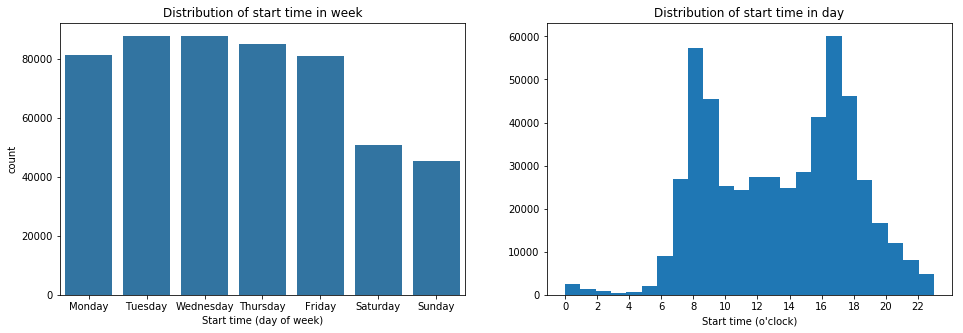

In [5]:
base_color = sb.color_palette()[0]
plt.figure(figsize = [16,5])

#Subplots for day of week
ax=plt.subplot(1,2,1)
sb.countplot(data=df, x=df.start_time.dt.weekday,color = base_color)
plt.xticks([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel('Start time (day of week)')
plt.title('Distribution of start time in week')

#Subplots for hour of day
ax=plt.subplot(1,2,2)
plt.hist(df.start_time.dt.hour,bins = 24)
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22])
plt.xlabel('Start time (o\'clock)')
plt.title('Distribution of start time in day');


## Distribution of Duration, Member Birth Year and Distance

Plotted on a logarithmic scale, the distribution of duration and distance takes on a normal distribution shape.  
Member birth year histogram appears as a left skewed distribution having major customer having birth year around 1980 to 1990.

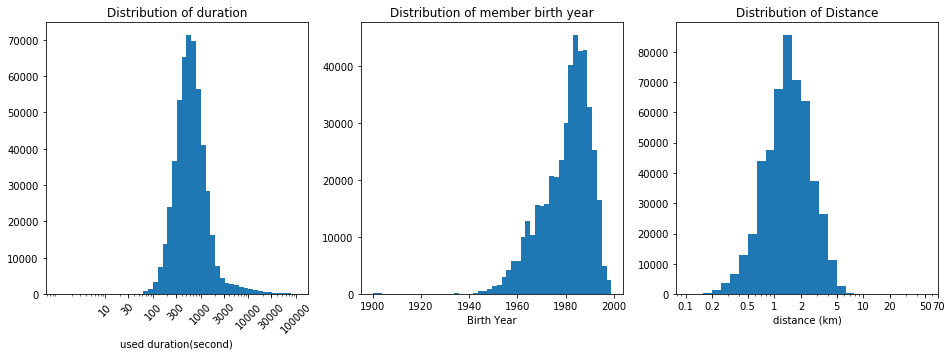

In [6]:

plt.figure(figsize = [16,5])

plt.subplot(1,3,1)
bin_du=10**np.arange(0,5+0.1,0.1)
plt.hist(df.duration_sec, bins = bin_du)
xtick=(10,30,100,300,1000,3000,10000,30000,100000)
xlabel=['{}'.format(x) for x in xtick]
plt.xscale('log')
plt.xticks(xtick, labels=xlabel, rotation = 45)
plt.xlabel('used duration(second)')
plt.title('Distribution of duration')

# Creat a sub dataset which excludes member birth year smaller than 1900
df_year= df[df.member_birth_year >= 1900]

plt.subplot(1,3,2)
plt.hist(df_year.member_birth_year, bins = 50)
plt.xlabel('Birth Year')
plt.title('Distribution of member birth year')

plt.subplot(1,3,3)
bins_dis=10**np.arange(-1,1.2 + 1/10,1/10)
plt.hist(df.distance, bins = bins_dis)
tick=[0.1,0.2,0.5,1,2,5,10,20,50,70]
labels=('{}'.format(x) for x in tick)
plt.xscale('log')
plt.xticks(tick, labels)
plt.xlabel('distance (km)')
plt.title('Distribution of Distance');

## User type vs Member gender

Male and subscriber user has higher proportion as expected than female and casual user.

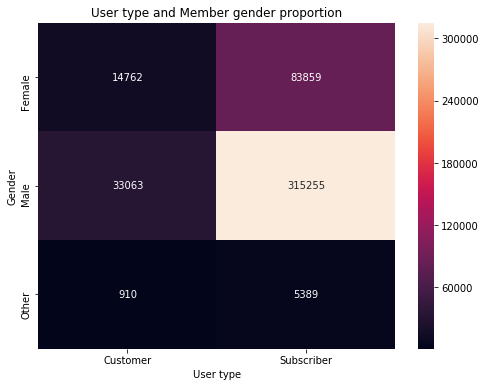

In [7]:
plt.figure(figsize=[8,6])

#Creat heatmap for these two categorical variables
ct_counts = df.groupby(['user_type', 'member_gender']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'member_gender', columns = 'user_type', values = 'count')
sb.heatmap(ct_counts,annot = True, fmt = 'd')
plt.ylabel('Gender')
plt.xlabel('User type')
plt.title('User type and Member gender proportion');

## Working age by time on weekday and weekend

There is a difference of the time people using bike between weekday and weekend. On weekday, people mostly use bike on starting time 8am and ending time 5pm of working hour, while on weekend after 10am to 6pm is time for all people using bike. However, retired people use bike on earlier time of a day and more on day time between 8am to 5pm on weekday. Moreover, on weekend, we can see at night, there is still amount of young people using bike.


In [8]:
bin_edges = np.arange(1900, 2010, 10)

#creat distance column for sub dataset df_year
df_year['distance']=df_year.apply(lambda x: geopy.distance.distance((x[5],x[6]),(x[9],x[10])).km,axis=1)

# cluster data as year user born
df_year['year_cut'] = pd.cut(df_year['member_birth_year'], bin_edges, right = False, include_lowest = True,
                  labels = ['00s','10s','20s','30s','40s','50s','60s','70s','80s','90s'])


df_year['year_cut'].value_counts()
#Creat a function to separate birth year as working age
def working_age(x):
    if x in ['00s','10s','20s','30s','40s','50s']:
        return 'retired'
    elif x in ['60s','70s']:
        return 'middle working age'
    else:
        return 'young working age'
    
#Apply this function on sub dataset
df_year['work_age']=df_year['year_cut'].apply(lambda x: working_age(x))

#Creat weekday column to take the value of weekday in start_time
df_year['weekday']=df_year.start_time.dt.weekday

#apply the function used to change weekday number  to string weekday name 
df_year['weekday']=df_year.weekday.apply(weekday)

#change weekday to ordered categorical type (created before)
df_year['weekday']=df_year['weekday'].astype(week_order)

#Create hour column to take the hour in start_time
df_year['hour']=df_year.start_time.dt.hour

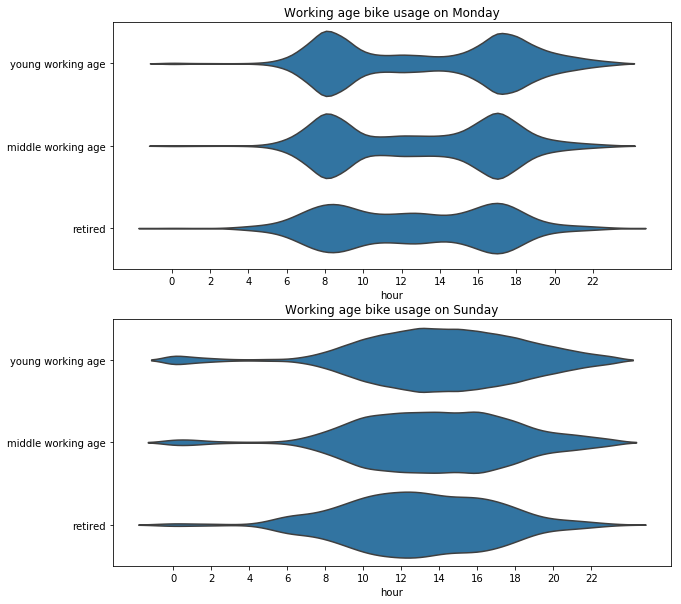

In [9]:
plt.figure(figsize=[10,10])

plt.subplot(2,1,1)
sb.violinplot(data = df_year[df['weekday']=='Monday'], x = 'hour', y = 'work_age', color = base_color,
              inner = None)
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22])
plt.title('Working age bike usage on Monday')
plt.ylabel('')


plt.subplot(2,1,2)
sb.violinplot(data = df_year[df['weekday']=='Sunday'], x = 'hour', y = 'work_age', color = base_color,
              inner = None)
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22])
plt.title('Working age bike usage on Sunday')
plt.ylabel('');

## Duration and Distance by User type at Day time of weekday and weekend

We can see that for duration factor, Casual(Customer) user suprisingly has higher using duration at all hours of day. Move on to Distance factor, on Monday, Casual user has higher in distance all hours of day (except at 11pm). On sunday, Subscribe user has little bit higher from 9am to 12pm and after 9pm.  



In [10]:
#Change user_type to ordered categorical type
types = ['Customer','Subscriber']
types_order= pd.api.types.CategoricalDtype(ordered = True, categories = types)
df['user_type']=df['user_type'].astype(types_order)

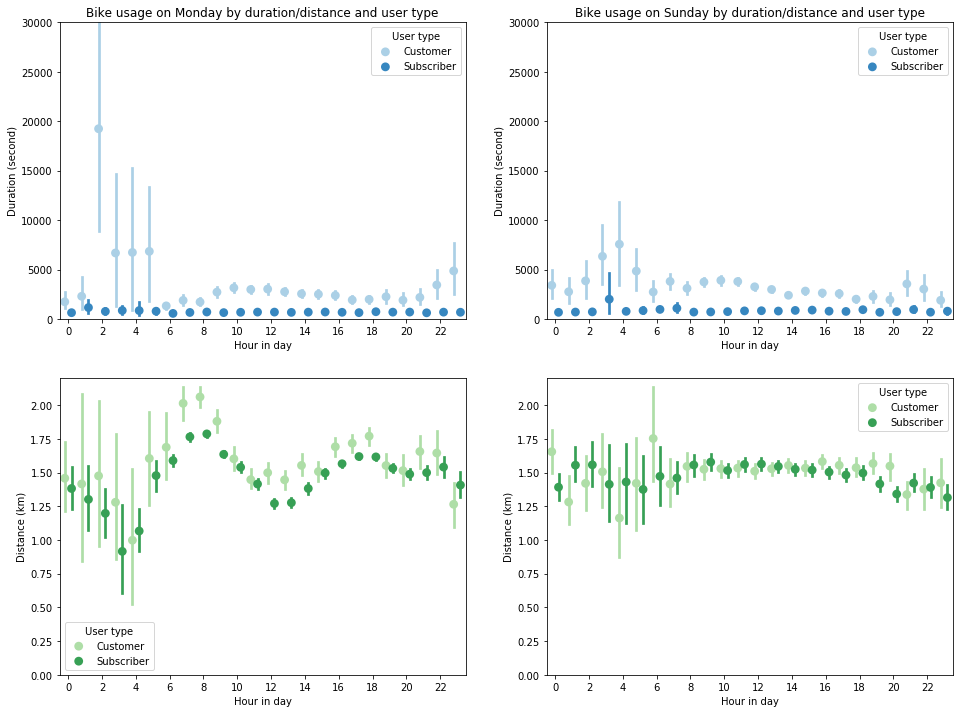

In [17]:
#Creat dogde plot on Monday and Sunday for duration and distance with user type
fig, ax = plt.subplots(ncols = 2, figsize = [16,12])
xtick=[0,2,4,6,8,10,12,14,16,18,20,22]
label=['{}'.format(x) for x in xtick]

plt.subplot(2,2,1)
sb.pointplot(data = df[df['weekday']=='Monday'], x = 'hour', y = 'duration_sec', hue = 'user_type',
             palette = 'Blues', linestyles = '', dodge = 0.4)
plt.xticks(xtick, labels =label)
plt.xlabel('Hour in day')
plt.ylabel('Duration (second)')
plt.title('Bike usage on Monday by duration/distance and user type')
plt.legend(title = 'User type')
plt.ylim(0,30000)

plt.subplot(2,2,2)
sb.pointplot(data = df[df['weekday']=='Sunday'], x = 'hour', y = 'duration_sec', hue = 'user_type',
             palette = 'Blues', linestyles = '', dodge = 0.4)
plt.xticks(xtick, labels =label)
plt.xlabel('Hour in day')
plt.ylabel('Duration (second)')
plt.title('Bike usage on Sunday by duration/distance and user type')
plt.legend(title = 'User type')
plt.ylim(0,30000)

plt.subplot(2,2,3)
sb.pointplot(data = df[df['weekday']=='Monday'], x = 'hour', y = 'distance', hue = 'user_type',
             palette = 'Greens', linestyles = '', dodge = 0.4)
plt.xticks(xtick, labels =label)
plt.xlabel('Hour in day')
plt.ylabel('Distance (km)')
plt.legend(title = 'User type')
plt.ylim(0,2.2)

plt.subplot(2,2,4)
sb.pointplot(data = df[df['weekday']=='Sunday'], x = 'hour', y = 'distance', hue = 'user_type',
             palette = 'Greens', linestyles = '', dodge = 0.4)
plt.xticks(xtick,labels =label)
plt.xlabel('Hour in day')
plt.ylabel('Distance (km)')
plt.legend(title = 'User type')
plt.ylim(0,2.2)
plt.show();

## Duration and Distance by Member gender at Day time of weekday and weekend

Reproducing the same plots with Member gender instead of User type grade shows that for Duration factor, Female user has higher duration usage all hours on Monday and Sunday, except on 3am. Compared to Distance facror, on Monday, Female user has little bit higher in distance at 6am to 8pm and it get lower at after 8pm. On Sunday, Male user has lower points all the hours, except after 2am to 5am. Probably, it suggests that female ride bike slowlier than male. 


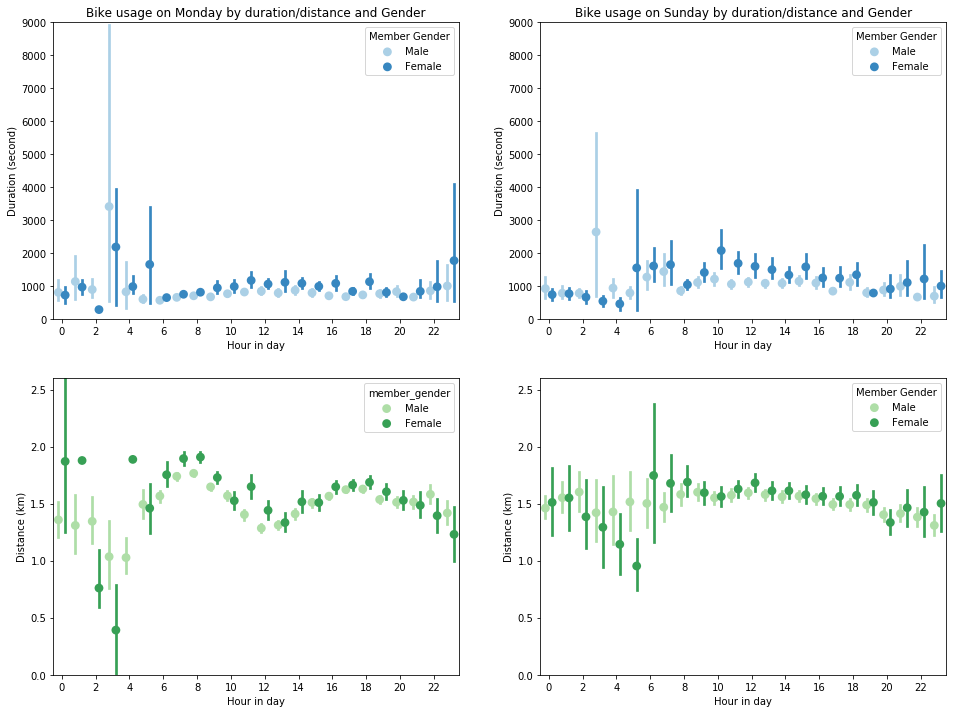

In [18]:
#Creat dogde plot on Monday and Sunday for duration and distance with member gender 
fig, ax = plt.subplots(ncols = 2, figsize = [16,12])

plt.subplot(2,2,1)
sb.pointplot(data = df.query('weekday =="Monday" & member_gender!= "Other"'), x = 'hour', y = 'duration_sec', hue = 'member_gender',
             palette = 'Blues', linestyles = '', dodge = 0.4)
plt.xticks(xtick, labels =label)
plt.xlabel('Hour in day')
plt.ylabel('Duration (second)')
plt.title('Bike usage on Monday by duration/distance and Gender')
plt.legend(title = 'Member Gender')
plt.ylim(0,9000)

plt.subplot(2,2,2)
sb.pointplot(data = df.query('weekday =="Sunday" & member_gender!= "Other"'), x = 'hour', y = 'duration_sec', hue = 'member_gender',
             palette = 'Blues', linestyles = '', dodge = 0.4)
plt.xticks(xtick, labels =label)
plt.xlabel('Hour in day')
plt.ylabel('Duration (second)')
plt.title('Bike usage on Sunday by duration/distance and Gender')
plt.legend(title = 'Member Gender')
plt.ylim(0,9000)

plt.subplot(2,2,3)
sb.pointplot(data = df.query('weekday =="Monday" & member_gender!= "Other"'), x = 'hour', y = 'distance', hue = 'member_gender',
             palette = 'Greens', linestyles = '', dodge = 0.4)
plt.xticks(xtick, labels =label)
plt.xlabel('Hour in day')
plt.ylabel('Distance (km)')
plt.ylim(0,2.6)

plt.subplot(2,2,4)
sb.pointplot(data = df.query('weekday =="Sunday" & member_gender!= "Other"'), x = 'hour', y = 'distance', hue = 'member_gender',
             palette = 'Greens', linestyles = '', dodge = 0.4)
plt.xticks(xtick,labels =label)
plt.xlabel('Hour in day')
plt.ylabel('Distance (km)')
plt.legend(title = 'Member Gender')
plt.ylim(0,2.6)
plt.show();

## Duration and Distance by Member gender and User type on Ages.

By the same plots with member birth year, Casual(Customer) type user has higher points in distance and duration in all ages. Although there are missing data for user born in 10s to 30s, Female user has higher points on distance usage almost at all ages, specially at young people (80s and 90s) while on Duration factor, Female user has higher points born from 30s to 90s.


In [13]:
df_year_gen=df_year[df_year.member_gender != 'Other']

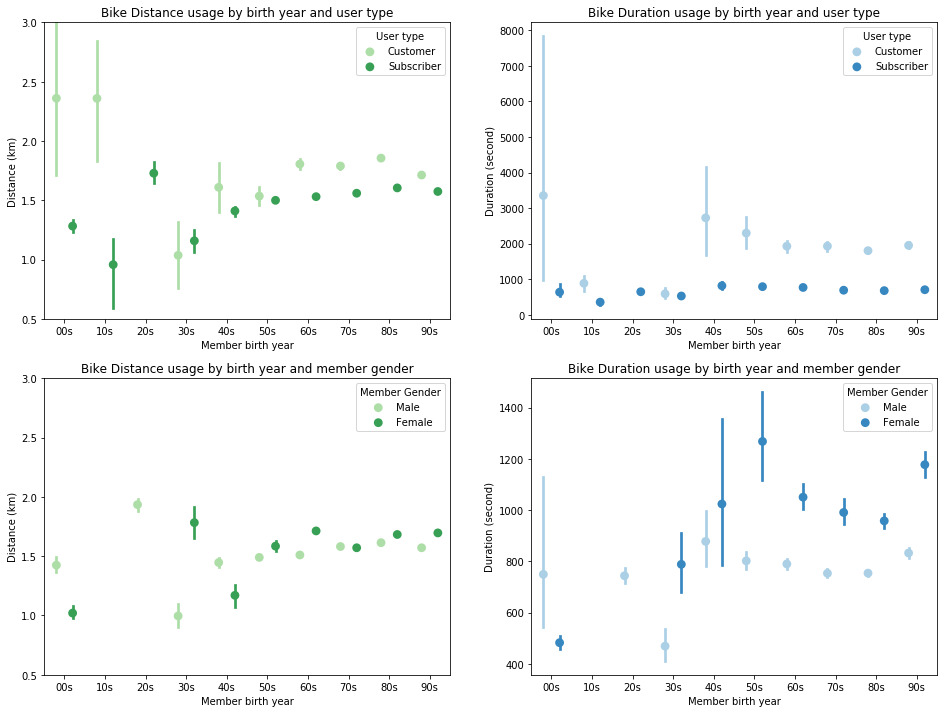

In [19]:
##Creat dogde plot on birth year for duration and distance with user type
plt.figure(figsize = [16, 12])
plt.subplot(2,2,1)
sb.pointplot(data = df_year, x = 'year_cut', y = 'distance',linestyles = '', hue = 'user_type',
             palette = 'Greens', dodge = 0.4)
plt.xlabel('Member birth year')
plt.ylabel('Distance (km)')
plt.legend(title = 'User type')
plt.ylim(0.5,3)
plt.title('Bike Distance usage by birth year and user type')

plt.subplot(2,2,2)
sb.pointplot(data = df_year, x = 'year_cut', y = 'duration_sec',linestyles = '', hue = 'user_type',
             palette = 'Blues', dodge = 0.4)
plt.xlabel('Member birth year')
plt.ylabel('Duration (second)')
plt.legend(title = 'User type')
plt.title('Bike Duration usage by birth year and user type')

plt.subplot(2,2,3)
sb.pointplot(data = df_year_gen, x = 'year_cut', y = 'distance',linestyles = '',hue = 'member_gender',
             palette = 'Greens', dodge = 0.4)
plt.xlabel('Member birth year')
plt.ylabel('Distance (km)')
plt.legend(title = 'Member Gender')
plt.ylim(0.5,3)
plt.title('Bike Distance usage by birth year and member gender')

plt.subplot(2,2,4)
sb.pointplot(data = df_year_gen, x = 'year_cut', y = 'duration_sec',linestyles = '', hue = 'member_gender',
             palette = 'Blues', dodge = 0.4)
plt.xlabel('Member birth year')
plt.ylabel('Duration (second)')
plt.legend(title = 'Member Gender')
plt.title('Bike Duration usage by birth year and member gender');

# Thank You !

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!